# Turing Target Practice

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [1]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

[ Info: Precompiling MCHMC [92da4d09-9da0-4f8a-8b31-da41ef0ab6ee]


In [2]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [3]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [4]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.2, 0.25)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [5]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [6]:
target = TuringTarget(stat_model);

In [7]:
eps=0.005
L=sqrt(2)
mchmc = Sampler(eps=eps, L=L, integrator="MN")

Sampler(Settings(Random.MersenneTwister(0), 0.005, 1.4142135623730951, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "MN"), MCHMC.Minimal_norm)

In [8]:
@time samples_mchmc = Sample(mchmc, target; num_steps=10000);

  5.494535 seconds (14.01 M allocations: 2.989 GiB, 13.19% gc time)


In [9]:
samples_mchmc = samples_mchmc[2000:end]

8002-element Vector{Vector{Float64}}:
 [0.2021526074641418, 0.8871347589253614]
 [0.20214527240904098, 0.8906388788905377]
 [0.20213751126672574, 0.89390404099519]
 [0.2021296543389104, 0.8970979785021702]
 [0.20212178914822482, 0.9002703261765314]
 [0.20211338715983784, 0.9030682368794445]
 [0.20210458134090756, 0.9055153899502777]
 [0.20209563120193977, 0.9077955391796656]
 [0.2020866249606793, 0.9099825035362772]
 [0.20207765543550107, 0.9121685856405097]
 [0.20206825554578667, 0.9137812729448873]
 [0.20205851539625364, 0.9146379938860819]
 [0.20204870460654759, 0.9150315795038068]
 ⋮
 [0.24999602126984855, 0.8223418574588306]
 [0.2499960189126055, 0.8273066248485816]
 [0.24999601533017335, 0.8322250115892526]
 [0.2499960121775941, 0.837162045808845]
 [0.24999600761061125, 0.842029245707982]
 [0.24999600355769974, 0.8469251952163391]
 [0.2499959991419392, 0.851801699225686]
 [0.24999599652615034, 0.8567587871614986]
 [0.24999599358345148, 0.8617044856731977]
 [0.24999599073682888, 0

## Plotting

In [10]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

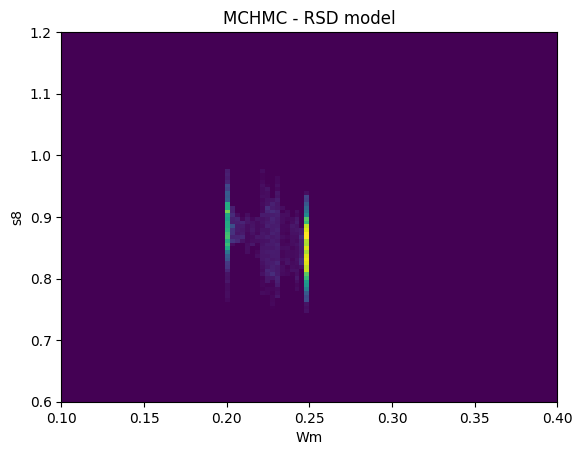

In [11]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [14]:
@time samples_hmc = sample(stat_model, NUTS(500, 0.65),
                  10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:17┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:02


 17.967034 seconds (53.40 M allocations: 8.652 GiB, 11.54% gc time)


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 7.97 seconds
Compute duration  = 7.97 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2244    0.0142     0.0001    0.0002   5987.7454    0.9999    ⋯
          σ8    0.8666    0.0393     0.0004    0.0005   6253.4455    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [15]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

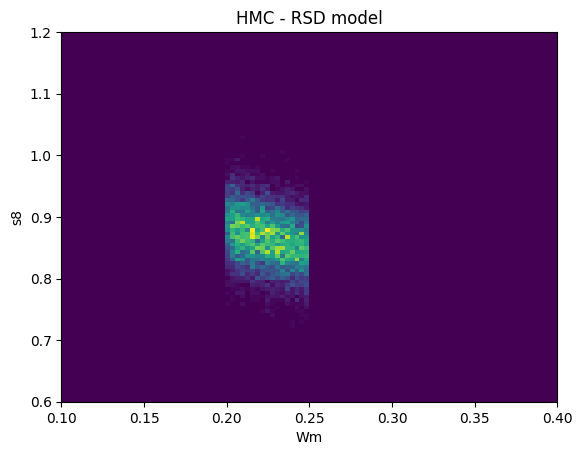

In [16]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");

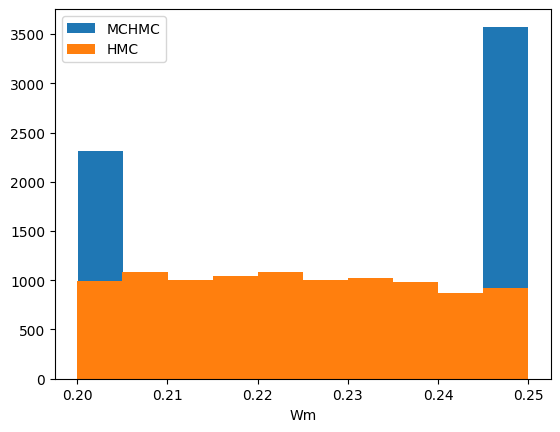

PyObject <matplotlib.legend.Legend object at 0x7f77efb75fd0>

In [17]:
plt.hist(Wms_mchmc, label="MCHMC")
plt.hist(Wms_hmc, label="HMC")
plt.xlabel("Wm")
plt.legend()

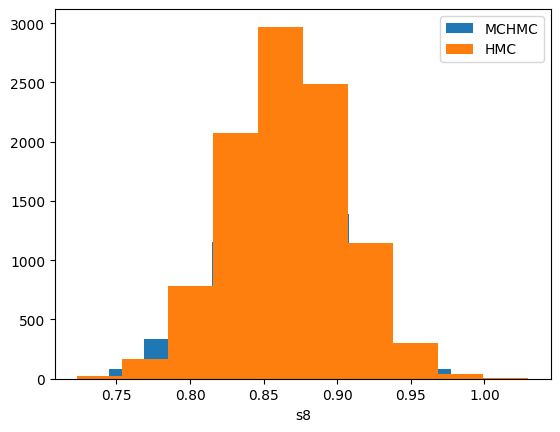

PyObject <matplotlib.legend.Legend object at 0x7f77efb44b20>

In [18]:
plt.hist(s8s_mchmc, label="MCHMC")
plt.hist(s8s_hmc, label="HMC")
plt.xlabel("s8")
plt.legend()

In [19]:
using AverageShiftedHistograms, Plots

LoadError: InitError: could not load library "/home/jaimerz/.julia/artifacts/1cfe0ebb804cb8b0d7d1e8f98e5cda94b2b31b3d/lib/libgobject-2.0.so"
/home/jaimerz/.julia/artifacts/1cfe0ebb804cb8b0d7d1e8f98e5cda94b2b31b3d/lib/libgobject-2.0.so: undefined symbol: g_uri_ref
during initialization of module Glib_jll

In [20]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

In [21]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Plots` not defined

In [22]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `Plots` not defined

## Self-tuning

In [22]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [23]:
mchmc.settings.tune_samples

1000

In [24]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

Self-tuning hyperparameters
Hyperparameter tuning (first stage)


LoadError: UndefVarError: `samples` not defined